## Work
1. 請改變 reduce_lr 的 patience 和 factor 並比較不同設定下，對訓練/驗證集的影響
2. 請將 optimizer 換成 Adam、RMSprop 搭配 reduce_lr 並比較訓練結果

In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[256, 256, 256]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [6]:
LEARNING_RATE = 1e-3
EPOCHS = 25 # IF you feel too run to finish, try to make it smaller
BATCH_SIZE = 1024 

In [7]:
# 載入 Callbacks
from keras.callbacks import ReduceLROnPlateau

optimizer_set = [keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=0.95),
                 keras.optimizers.Adam(lr=LEARNING_RATE),
                 keras.optimizers.RMSprop(lr=LEARNING_RATE)]

"""Code Here
建立實驗的比較組合
"""
reduce_lr_factor = [0.99, 0.5, 0.1]
redice_lr_patient = [3,5,10]

In [8]:
import itertools
results = {}
for i, (optim, reduce_factor, reduce_patient) in enumerate(itertools.product(optimizer_set, reduce_lr_factor, redice_lr_patient)):
    print("Numbers of exp: %i, reduce_factor: %.2f, reduce_patient: %i" % (i, reduce_factor, reduce_patient))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optim)
    
    """Code Here
    設定 reduce learning rate 的 callback function
    """
    reduce_lr = ReduceLROnPlateau(factor=reduce_factor, 
                              min_lr=1e-12, 
                              monitor='val_loss', 
                              patience=reduce_patient, 
                              verbose=1)
    
    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_SIZE, 
              validation_data=(x_test, y_test), 
              shuffle=True,
              callbacks=[reduce_lr]
             )

    # Collect results
    exp_name_tag = ("exp-%s" % (i))
    results[exp_name_tag] = {'train-loss': model.history.history["loss"],
                             'valid-loss': model.history.history["val_loss"],
                             'train-acc': model.history.history["acc"],
                             'valid-acc': model.history.history["val_acc"]}

W0723 07:57:18.526263  1476 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0723 07:57:18.530250  1476 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0723 07:57:18.537984  1476 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



Numbers of exp: 0, reduce_factor: 0.99, reduce_patient: 3


W0723 07:57:18.768978  1476 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0723 07:57:19.252106  1476 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0723 07:57:19.268125  1476 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 256)               65792     
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
__________

W0723 07:57:19.534145  1476 deprecation.py:323] From C:\Users\weihs\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 12s 231us/step - loss: 2.2354 - acc: 0.2639 - val_loss: 2.1653 - val_acc: 0.3163
Epoch 2/25
50000/50000 [==============================] - 9s 189us/step - loss: 1.7638 - acc: 0.3856 - val_loss: 1.8209 - val_acc: 0.3753
Epoch 3/25
50000/50000 [==============================] - 10s 196us/step - loss: 1.6359 - acc: 0.4280 - val_loss: 1.7220 - val_acc: 0.3926
Epoch 4/25
50000/50000 [==============================] - 9s 184us/step - loss: 1.5624 - acc: 0.4539 - val_loss: 1.6372 - val_acc: 0.4241
Epoch 5/25
50000/50000 [==============================] - 10s 198us/step - loss: 1.5082 - acc: 0.4739 - val_loss: 1.6048 - val_acc: 0.4347
Epoch 6/25
50000/50000 [==============================] - 10s 202us/step - loss: 1.4637 - acc: 0.4892 - val_loss: 1.5716 - val_acc: 0.4486
Epoch 7/25
50000/50000 [==============================] - 10s 192us/step - loss: 1.4248 - acc: 0.5026 - val_loss: 1.55

50000/50000 [==============================] - 6s 116us/step - loss: 1.0783 - acc: 0.6315 - val_loss: 1.4413 - val_acc: 0.4983
Epoch 24/25
50000/50000 [==============================] - 6s 116us/step - loss: 1.0614 - acc: 0.6390 - val_loss: 1.4451 - val_acc: 0.4965
Epoch 25/25
50000/50000 [==============================] - 6s 116us/step - loss: 1.0446 - acc: 0.6447 - val_loss: 1.4553 - val_acc: 0.4960
Numbers of exp: 2, reduce_factor: 0.99, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_7 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_l

50000/50000 [==============================] - 6s 128us/step - loss: 1.3336 - acc: 0.5336 - val_loss: 1.5095 - val_acc: 0.4698
Epoch 11/25
50000/50000 [==============================] - 7s 132us/step - loss: 1.3078 - acc: 0.5419 - val_loss: 1.5032 - val_acc: 0.4720
Epoch 12/25
50000/50000 [==============================] - 7s 131us/step - loss: 1.2839 - acc: 0.5528 - val_loss: 1.4913 - val_acc: 0.4771
Epoch 13/25
50000/50000 [==============================] - 7s 131us/step - loss: 1.2621 - acc: 0.5599 - val_loss: 1.4868 - val_acc: 0.4794
Epoch 14/25
50000/50000 [==============================] - 7s 134us/step - loss: 1.2416 - acc: 0.5671 - val_loss: 1.4663 - val_acc: 0.4866
Epoch 15/25
50000/50000 [==============================] - 7s 132us/step - loss: 1.2199 - acc: 0.5773 - val_loss: 1.4749 - val_acc: 0.4824
Epoch 16/25
50000/50000 [==============================] - 7s 135us/step - loss: 1.1995 - acc: 0.5834 - val_loss: 1.4585 - val_acc: 0.4867
Epoch 17/25
50000/50000 [==============

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 10s 190us/step - loss: 2.4193 - acc: 0.2253 - val_loss: 2.2207 - val_acc: 0.2922
Epoch 2/25
50000/50000 [==============================] - 8s 156us/step - loss: 1.9155 - acc: 0.3426 - val_loss: 1.9675 - val_acc: 0.3430
Epoch 3/25
50000/50000 [==============================] - 9s 181us/step - loss: 1.7647 - acc: 0.3856 - val_loss: 1.8420 - val_acc: 0.3686
Epoch 4/25
50000/50000 [==============================] - 8s 163us/step - loss: 1.6803 - acc: 0.4110 - val_loss: 1.7446 - val_acc: 0.3854
Epoch 5/25
50000/50000 [==============================] - 8s 156us/step - loss: 1.6228 - acc: 0.4307 - val_loss: 1.6973 - val_acc: 0.4058
Epoch 6/25
50000/50000 [==============================] - 7s 146us/step - loss: 1.5796 - acc: 0.4457 - val_loss: 1.6666 - val_acc: 0.4200
Epoch 7/25
50000/50000 [==============================] - 7s 147us/step - loss: 1.5457 - acc: 0.4586 - val_loss: 1.6417 -

Epoch 24/25
50000/50000 [==============================] - 8s 169us/step - loss: 1.2238 - acc: 0.5728 - val_loss: 1.4818 - val_acc: 0.4757
Epoch 25/25
50000/50000 [==============================] - 9s 170us/step - loss: 1.2112 - acc: 0.5785 - val_loss: 1.4757 - val_acc: 0.4824
Numbers of exp: 7, reduce_factor: 0.10, reduce_patient: 5
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_22 (Batc (None, 256)               1024      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               65792     
_________________________________________________________________
batc

50000/50000 [==============================] - 8s 160us/step - loss: 1.4315 - acc: 0.5003 - val_loss: 1.5693 - val_acc: 0.4501
Epoch 12/25
50000/50000 [==============================] - 8s 159us/step - loss: 1.4101 - acc: 0.5090 - val_loss: 1.5527 - val_acc: 0.4541
Epoch 13/25
50000/50000 [==============================] - 8s 159us/step - loss: 1.3900 - acc: 0.5165 - val_loss: 1.5454 - val_acc: 0.4587
Epoch 14/25
50000/50000 [==============================] - 8s 158us/step - loss: 1.3707 - acc: 0.5242 - val_loss: 1.5403 - val_acc: 0.4565
Epoch 15/25
50000/50000 [==============================] - 8s 156us/step - loss: 1.3544 - acc: 0.5297 - val_loss: 1.5374 - val_acc: 0.4580
Epoch 16/25
50000/50000 [==============================] - 8s 157us/step - loss: 1.3375 - acc: 0.5342 - val_loss: 1.5249 - val_acc: 0.4652
Epoch 17/25
50000/50000 [==============================] - 8s 160us/step - loss: 1.3221 - acc: 0.5400 - val_loss: 1.5304 - val_acc: 0.4666
Epoch 18/25
50000/50000 [==============

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 9s 180us/step - loss: 1.8235 - acc: 0.3613 - val_loss: 1.8153 - val_acc: 0.3734
Epoch 2/25
50000/50000 [==============================] - 7s 143us/step - loss: 1.5600 - acc: 0.4441 - val_loss: 1.7070 - val_acc: 0.3928
Epoch 3/25
50000/50000 [==============================] - 7s 142us/step - loss: 1.4659 - acc: 0.4805 - val_loss: 1.6030 - val_acc: 0.4350
Epoch 4/25
50000/50000 [==============================] - 7s 141us/step - loss: 1.3856 - acc: 0.5064 - val_loss: 1.7306 - val_acc: 0.4000
Epoch 5/25
50000/50000 [==============================] - 7s 140us/step - loss: 1.3296 - acc: 0.5262 - val_loss: 1.5470 - val_acc: 0.4478
Epoch 6/25
50000/50000 [==============================] - 7s 140us/step - loss: 1.2768 - acc: 0.5470 - val_loss: 1.5423 - val_acc: 0.4516
Epoch 7/25
50000/50000 [==============================] - 7s 139us/step - loss: 1.2226 - acc: 0.5644 - val_loss: 1.4904 - 

50000/50000 [==============================] - 7s 139us/step - loss: 0.7327 - acc: 0.7437 - val_loss: 1.6089 - val_acc: 0.5012
Epoch 23/25
50000/50000 [==============================] - 7s 139us/step - loss: 0.6967 - acc: 0.7572 - val_loss: 1.6935 - val_acc: 0.4900
Epoch 24/25
50000/50000 [==============================] - 7s 141us/step - loss: 0.6725 - acc: 0.7664 - val_loss: 1.6874 - val_acc: 0.4865

Epoch 00024: ReduceLROnPlateau reducing learning rate to 0.0009135173546383158.
Epoch 25/25
50000/50000 [==============================] - 7s 144us/step - loss: 0.6382 - acc: 0.7792 - val_loss: 1.7739 - val_acc: 0.4581
Numbers of exp: 12, reduce_factor: 0.50, reduce_patient: 3
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)            

50000/50000 [==============================] - 7s 139us/step - loss: 1.2940 - acc: 0.5500 - val_loss: 1.4936 - val_acc: 0.4655
Epoch 7/25
50000/50000 [==============================] - 7s 141us/step - loss: 1.2563 - acc: 0.5631 - val_loss: 1.5016 - val_acc: 0.4669
Epoch 8/25
50000/50000 [==============================] - 7s 143us/step - loss: 1.2233 - acc: 0.5754 - val_loss: 1.5112 - val_acc: 0.4652
Epoch 9/25
50000/50000 [==============================] - 7s 140us/step - loss: 1.1924 - acc: 0.5888 - val_loss: 1.4438 - val_acc: 0.4907
Epoch 10/25
50000/50000 [==============================] - 8s 160us/step - loss: 1.1643 - acc: 0.5978 - val_loss: 1.4584 - val_acc: 0.4811
Epoch 11/25
50000/50000 [==============================] - 7s 143us/step - loss: 1.1398 - acc: 0.6055 - val_loss: 1.4497 - val_acc: 0.4937
Epoch 12/25
50000/50000 [==============================] - 7s 141us/step - loss: 1.1170 - acc: 0.6154 - val_loss: 1.4155 - val_acc: 0.5049
Epoch 13/25
50000/50000 [=================

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 10s 201us/step - loss: 2.0250 - acc: 0.3176 - val_loss: 1.9204 - val_acc: 0.3536
Epoch 2/25
50000/50000 [==============================] - 7s 147us/step - loss: 1.6490 - acc: 0.4238 - val_loss: 1.7006 - val_acc: 0.4062
Epoch 3/25
50000/50000 [==============================] - 8s 167us/step - loss: 1.5499 - acc: 0.4566 - val_loss: 1.6660 - val_acc: 0.4172
Epoch 4/25
50000/50000 [==============================] - 9s 175us/step - loss: 1.4907 - acc: 0.4785 - val_loss: 1.6082 - val_acc: 0.4389
Epoch 5/25
50000/50000 [==============================] - 9s 174us/step - loss: 1.4433 - acc: 0.4952 - val_loss: 1.5955 - val_acc: 0.4429
Epoch 6/25
50000/50000 [==============================] - 9s 184us/step - loss: 1.4060 - acc: 0.5089 - val_loss: 1.5541 - val_acc: 0.4525
Epoch 7/25
50000/50000 [==============================] - 9s 173us/step - loss: 1.3748 - acc: 0.5213 - val_loss: 1.5448 -

50000/50000 [==============================] - 12s 240us/step - loss: 1.0947 - acc: 0.6244 - val_loss: 1.4523 - val_acc: 0.4883
Epoch 24/25
50000/50000 [==============================] - 10s 198us/step - loss: 1.0827 - acc: 0.6297 - val_loss: 1.4442 - val_acc: 0.5006
Epoch 25/25
50000/50000 [==============================] - 9s 173us/step - loss: 1.0721 - acc: 0.6332 - val_loss: 1.4403 - val_acc: 0.4972
Numbers of exp: 17, reduce_factor: 0.10, reduce_patient: 10
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 256)               786688    
_________________________________________________________________
batch_normalization_52 (Batc (None, 256)               1024      
_________________________________________________________________
hidde

50000/50000 [==============================] - 9s 177us/step - loss: 1.0542 - acc: 0.6278 - val_loss: 1.7665 - val_acc: 0.4246
Epoch 11/25
50000/50000 [==============================] - 10s 196us/step - loss: 1.0157 - acc: 0.6441 - val_loss: 1.7066 - val_acc: 0.4175
Epoch 12/25
50000/50000 [==============================] - 10s 206us/step - loss: 0.9788 - acc: 0.6579 - val_loss: 1.9677 - val_acc: 0.3980
Epoch 13/25
50000/50000 [==============================] - 10s 209us/step - loss: 0.9441 - acc: 0.6713 - val_loss: 1.6378 - val_acc: 0.4553
Epoch 14/25
50000/50000 [==============================] - 10s 209us/step - loss: 0.9075 - acc: 0.6831 - val_loss: 1.7981 - val_acc: 0.4159
Epoch 15/25
50000/50000 [==============================] - 10s 207us/step - loss: 0.8714 - acc: 0.6966 - val_loss: 1.9826 - val_acc: 0.4025
Epoch 16/25
50000/50000 [==============================] - 10s 205us/step - loss: 0.8386 - acc: 0.7066 - val_loss: 1.7502 - val_acc: 0.4427

Epoch 00016: ReduceLROnPlateau r

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 25s 497us/step - loss: 1.8335 - acc: 0.3656 - val_loss: 2.4698 - val_acc: 0.2664
Epoch 2/25
50000/50000 [==============================] - 18s 354us/step - loss: 1.5401 - acc: 0.4530 - val_loss: 2.1402 - val_acc: 0.2982
Epoch 3/25
50000/50000 [==============================] - 17s 344us/step - loss: 1.4242 - acc: 0.4959 - val_loss: 2.8483 - val_acc: 0.2440
Epoch 4/25
50000/50000 [==============================] - 17s 344us/step - loss: 1.3421 - acc: 0.5261 - val_loss: 2.2586 - val_acc: 0.2977
Epoch 5/25
50000/50000 [==============================] - 17s 346us/step - loss: 1.2841 - acc: 0.5438 - val_loss: 2.0167 - val_acc: 0.3428
Epoch 6/25
50000/50000 [==============================] - 18s 355us/step - loss: 1.2232 - acc: 0.5696 - val_loss: 2.0472 - val_acc: 0.3245
Epoch 7/25
50000/50000 [==============================] - 18s 350us/step - loss: 1.1730 - acc: 0.5873 - val_loss: 2.

50000/50000 [==============================] - 18s 351us/step - loss: 0.6423 - acc: 0.7958 - val_loss: 1.4003 - val_acc: 0.5375
Epoch 22/25
50000/50000 [==============================] - 17s 348us/step - loss: 0.6297 - acc: 0.8002 - val_loss: 1.4031 - val_acc: 0.5350

Epoch 00022: ReduceLROnPlateau reducing learning rate to 5.884251731913537e-05.
Epoch 23/25
50000/50000 [==============================] - 18s 352us/step - loss: 0.6048 - acc: 0.8116 - val_loss: 1.3967 - val_acc: 0.5401
Epoch 24/25
50000/50000 [==============================] - 17s 346us/step - loss: 0.5980 - acc: 0.8148 - val_loss: 1.3936 - val_acc: 0.5418
Epoch 25/25
50000/50000 [==============================] - 17s 343us/step - loss: 0.5915 - acc: 0.8163 - val_loss: 1.4051 - val_acc: 0.5444

Epoch 00025: ReduceLROnPlateau reducing learning rate to 2.9421258659567684e-05.
Numbers of exp: 22, reduce_factor: 0.50, reduce_patient: 5
_________________________________________________________________
Layer (type)            

50000/50000 [==============================] - 18s 360us/step - loss: 1.5701 - acc: 0.4516 - val_loss: 1.6713 - val_acc: 0.4192
Epoch 8/25
50000/50000 [==============================] - 18s 358us/step - loss: 1.5311 - acc: 0.4642 - val_loss: 1.6617 - val_acc: 0.4241
Epoch 9/25
50000/50000 [==============================] - 18s 351us/step - loss: 1.4992 - acc: 0.4749 - val_loss: 1.6392 - val_acc: 0.4314
Epoch 10/25
50000/50000 [==============================] - 18s 357us/step - loss: 1.4692 - acc: 0.4863 - val_loss: 1.6152 - val_acc: 0.4345
Epoch 11/25
50000/50000 [==============================] - 18s 368us/step - loss: 1.4437 - acc: 0.4965 - val_loss: 1.6011 - val_acc: 0.4454
Epoch 12/25
50000/50000 [==============================] - 19s 373us/step - loss: 1.4193 - acc: 0.5038 - val_loss: 1.5848 - val_acc: 0.4505
Epoch 13/25
50000/50000 [==============================] - 18s 357us/step - loss: 1.3955 - acc: 0.5159 - val_loss: 1.5699 - val_acc: 0.4525
Epoch 14/25
50000/50000 [=========

Train on 50000 samples, validate on 10000 samples
Epoch 1/25
50000/50000 [==============================] - 26s 524us/step - loss: 2.2465 - acc: 0.2446 - val_loss: 2.1123 - val_acc: 0.2930
Epoch 2/25
50000/50000 [==============================] - 18s 351us/step - loss: 1.9077 - acc: 0.3387 - val_loss: 1.9759 - val_acc: 0.3349
Epoch 3/25
50000/50000 [==============================] - 18s 357us/step - loss: 1.7817 - acc: 0.3786 - val_loss: 1.8306 - val_acc: 0.3672
Epoch 4/25
50000/50000 [==============================] - 18s 359us/step - loss: 1.7010 - acc: 0.4057 - val_loss: 1.7733 - val_acc: 0.3805
Epoch 5/25
50000/50000 [==============================] - 18s 357us/step - loss: 1.6423 - acc: 0.4248 - val_loss: 1.7204 - val_acc: 0.3937
Epoch 6/25
50000/50000 [==============================] - 18s 354us/step - loss: 1.5946 - acc: 0.4428 - val_loss: 1.6859 - val_acc: 0.4096
Epoch 7/25
50000/50000 [==============================] - 18s 356us/step - loss: 1.5550 - acc: 0.4565 - val_loss: 1.

50000/50000 [==============================] - 18s 354us/step - loss: 1.2437 - acc: 0.5731 - val_loss: 1.5136 - val_acc: 0.4692
Epoch 24/25
50000/50000 [==============================] - 18s 358us/step - loss: 1.2317 - acc: 0.5760 - val_loss: 1.5034 - val_acc: 0.4731
Epoch 25/25
50000/50000 [==============================] - 18s 359us/step - loss: 1.2178 - acc: 0.5796 - val_loss: 1.5027 - val_acc: 0.4727


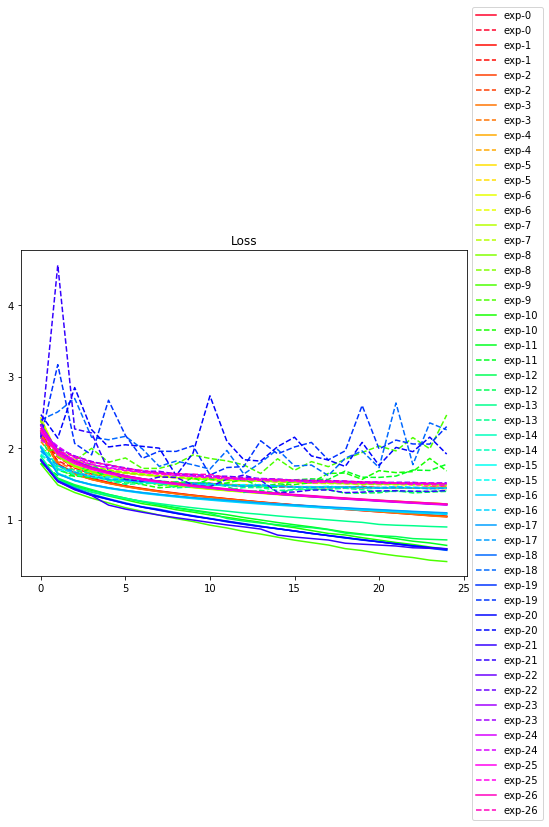

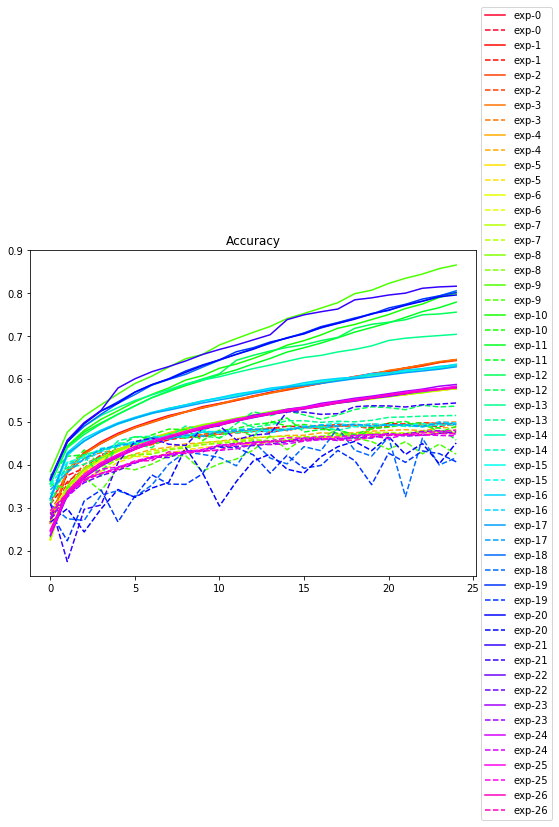

In [9]:
import matplotlib.pyplot as plt
import matplotlib.cm as mplcm
import matplotlib.colors as colors
%matplotlib inline
NUM_COLORS = len(results.keys())

cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=NUM_COLORS-1)
scalarMap = mplcm.ScalarMappable(norm=cNorm, cmap=cm)
color_bar = [scalarMap.to_rgba(i) for i in range(NUM_COLORS)]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()